# Tutorial

This is a tutorial for MB-MVPA using task-fMRI data of Mixed-gamble task by Tom et al., 2007. 



### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [1]:
from time import perf_counter

In [2]:
from mbmvpa.preprocessing.preprocess import DataPreprocessor

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


TODO: add original data download link

Data download from AWS S3, ~ <b>1GB</b> (would be under the "Mixed-gamble_task/example_data/").<br>

We provide a small subset (2 subjects) of original Tom's dataset (16 subjects). The fMRI images in the example is preprocessed by conventional fMRI preprocessing pipeline by using 
[*fmriprep*](https://fmriprep.org/en/stable/) v.20.1.0. Please refer to the [original](https://openneuro.org/datasets/ds000005/versions/00001) for more information.

In [3]:
#root = load_example_data("tom")
root = "/data2/project_modelbasedMVPA/ds000005"

### Preprocessing fMRI images and behavioral data

MB-MVPA requires primariliy preprocessed task-fMRI experiments data fromatted in conventional [BIDS format](https://bids-specification.readthedocs.io/en/stable/) 

It expects the following organized files. All the naming conventions used here conform with outputs from *fmriprep* v.20.1.0. by Poldrack lab.

The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

In [4]:
s = perf_counter()

dm_model = 'ra_prospect'

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_filter(row):
    # include all trial data
    return True

def example_latent(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row


preprocessor = DataPreprocessor(bids_layout=root,
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               latent_function=example_latent,
                               dm_model=dm_model,
                               mask_threshold=2.58,
                               standardize=True,
                               confounds=[],
                               high_pass=1/128,
                               detrend=False,
                               smoothing_fwhm=6, 
                               confounds=[], #["trans_x", "trans_y","trans_z", "rot_x", "rot_y", "rot_z"]
                               zoom=(2,2,2))

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.44 minutes


In [5]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


In [6]:
preprocessor.X_generator.bids_controller.fmriprep_layout.root

'/data2/project_modelbasedMVPA/ds000005/derivatives/fmriprep'

In [7]:
preprocessor.X_generator.mask_path

PosixPath('/data2/project_modelbasedMVPA/ds000005/derivatives/fmriprep/masks')

In [8]:
s = perf_counter()

#preprocessor.preprocess(overwrite=True,n_core=16)
#preprocessor.preprocess(overwrite=False,n_core=16)
preprocessor.X_generator.run(overwrite=True)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

gain_association-test_z_FDR_0.01.nii: 1595/902629
gain_association-test_z_FDR_0.01.nii: 1595/902629
gain_association-test_z_FDR_0.01.nii: 7378/902629
gain_association-test_z_FDR_0.01.nii: 783/902629
gain_association-test_z_FDR_0.01.nii: 9764/902629
gain_association-test_z_FDR_0.01.nii: 12969/902629
integrated mask: 22192/902629
zommed : 2236/116380


12it [03:08, 15.73s/it]

elapsed time: 3.27 minutes


In [9]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


### Load data and shape check

In [10]:
from mbmvpa.data.loader import BIDSDataLoader

In [11]:
s = perf_counter()

loader = BIDSDataLoader(layout=root)
X,y = loader.get_data(subject_wise=False)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.17 minutes


In [12]:
print("X", X.shape)
print("y", y.shape)

X (11520, 2236)
y (11520, 1)


In [13]:
voxel_mask = loader.get_voxel_mask()

### Fitting MVPA models & Results

In [14]:
from mbmvpa.models.mvpa_elasticnet import elasticnet

- lambda_best: 0.559, mse: 0.1161, survival rate (non-zero): 1732/2236


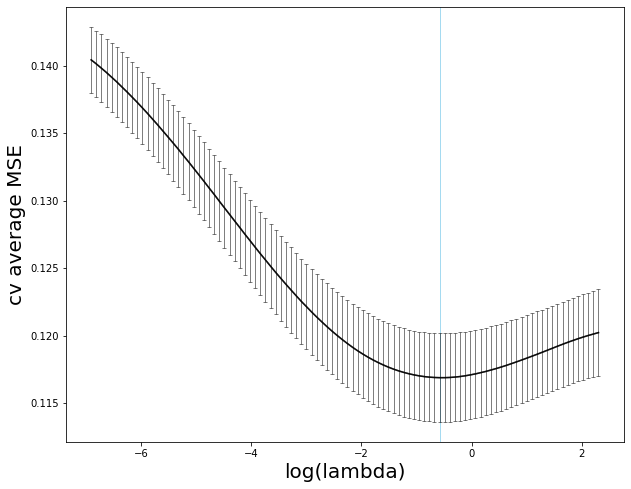

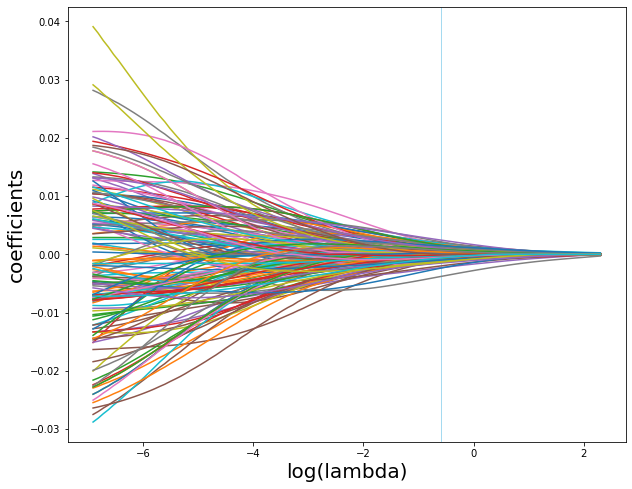

elapsed time: 1.60 minutes


In [15]:
s = perf_counter()
coef,intercept = elasticnet(X=X,
                  y=y,
                  voxel_mask=voxel_mask,
                  save_path='.',
                  sigma=0)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

In [16]:
from mbmvpa.models.mvpa_elasticnet import elasticnet_crossvalidation

In [17]:
#loader = BIDSDataLoader(layout=root)
X_dict,y_dict = loader.get_data(subject_wise=True)

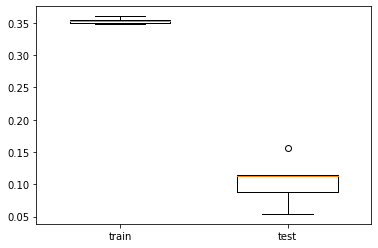

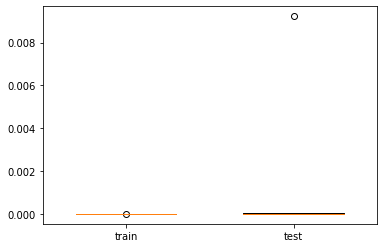

In [18]:
metrics_train, metrics_test, coefs_train = elasticnet_crossvalidation(X_dict,
                                                                       y_dict
                                                                     method='5-fold')

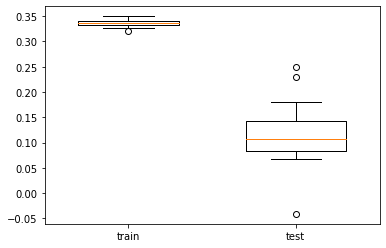

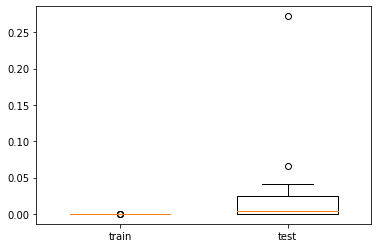

In [20]:
metrics_train, metrics_test, coefs_train = elasticnet_crossvalidation(X_dict,
                                                                       y_dict,
                                                                     method='loso')

In [21]:
metrics_test

array([[ 1.05796737e-01,  4.48496130e-03],
       [ 2.50146116e-01,  9.82782156e-12],
       [ 8.53407485e-02,  2.20136088e-02],
       [ 2.30120505e-01,  4.15488978e-10],
       [ 6.84945290e-02,  6.62297769e-02],
       [ 1.22306115e-01,  1.00733992e-03],
       [ 8.53724696e-02,  2.19641455e-02],
       [ 9.87913093e-02,  7.98425480e-03],
       [ 1.36185456e-01,  2.47359904e-04],
       [ 1.23989932e-01,  8.55783657e-04],
       [-4.09960582e-02,  2.71946840e-01],
       [ 7.98955746e-02,  3.20709001e-02],
       [ 1.58204468e-01,  2.00278328e-05],
       [ 7.61699105e-02,  4.10256143e-02],
       [ 1.80277229e-01,  1.12228768e-06],
       [ 1.06670906e-01,  4.16368262e-03]])

In [22]:
metrics_test[:,0]

array([ 0.10579674,  0.25014612,  0.08534075,  0.23012051,  0.06849453,
        0.12230611,  0.08537247,  0.09879131,  0.13618546,  0.12398993,
       -0.04099606,  0.07989557,  0.15820447,  0.07616991,  0.18027723,
        0.10667091])

In [26]:
metrics_test[:,0][metrics_test[:,1] <0.01]

array([0.10579674, 0.25014612, 0.23012051, 0.12230611, 0.09879131,
       0.13618546, 0.12398993, 0.15820447, 0.18027723, 0.10667091])